In [99]:
%matplotlib inline


# Outlier detection on a real data set

This example illustrates the need for robust covariance estimation
on a real data set. It is useful both for outlier detection and for
a better understanding of the data structure.

We selected two sets of two variables from the Wine data set
as an illustration of what kind of analysis can be done with several
outlier detection tools. For the purpose of visualization, we are working
with two-dimensional examples, but one should be aware that things are
not so trivial in high-dimension, as it will be pointed out.

In both examples below, the main result is that the empirical covariance
estimate, as a non-robust one, is highly influenced by the heterogeneous
structure of the observations. Although the robust covariance estimate is
able to focus on the main mode of the data distribution, it sticks to the
assumption that the data should be Gaussian distributed, yielding some biased
estimation of the data structure, but yet accurate to some extent.
The One-Class SVM does not assume any parametric form of the data distribution
and can therefore model the complex shape of the data much better.


In [100]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine


data_bunch = load_wine()
data = data_bunch['data']
# Load data about the rows and columns
feature_names = data_bunch['feature_names']

# Load cultivar information about each wine
cultivars = np.array([f'Cultivar{cl}' for cl in data_bunch['target']])

# Create nice names for each row
wine_names = np.array([f'Wine{i}' for i in range(data.shape[0])])

# Gather all of this information into a DataFrame
data = pd.DataFrame(data, columns=feature_names, index=wine_names)

# Print the first 5 rows of the data, eq. to data[:5]
# data.head()
data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
Wine0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
Wine1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
Wine2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
Wine3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
Wine4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wine173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
Wine174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
Wine175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
Wine176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0



## First example
The first example illustrates how the Minimum Covariance Determinant
robust estimator can help concentrate on a relevant cluster when outlying
points exist. Here the empirical covariance estimation is skewed by points
outside of the main cluster. Of course, some screening tools would have pointed
out the presence of two clusters (Support Vector Machines, Gaussian Mixture
Models, univariate outlier detection, ...). But had it been a high-dimensional
example, none of these could be applied that easily.


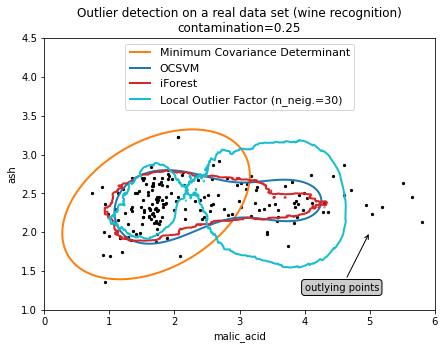

In [101]:
# Author: Virgile Fritsch <virgile.fritsch@inria.fr>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

SEED = 24

# Define "classifiers" to be used
classifiers = {
    # "Empirical Covariance": EllipticEnvelope(support_fraction=1.0, contamination=0.25),
    "Minimum Covariance Determinant": EllipticEnvelope(
        contamination=0.25
    ),
    "OCSVM": OneClassSVM(nu=0.25, gamma=0.35),
    "iForest": IsolationForest(contamination=0.25, random_state=SEED),
    # default
    "Local Outlier Factor (n_neig.=30)": LocalOutlierFactor(n_neighbors=30, contamination=0.25, novelty=True)
}
colors = ["C1", "C0", "C3", "C9"]
legend1 = {}
legend2 = {}

# Get data
features = ['malic_acid', 'ash']
X1 = data[features].to_numpy()  # two clusters

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    CS = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i]
    )
    legend1[clf_name], _ = CS.legend_elements()

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())


# Plot the results (= shape of the data points cloud)
plt.figure(1)  # two clusters
plt.title("Outlier detection on a real data set (wine recognition)\ncontamination=0.25")
plt.scatter(X1[:, 0], X1[:, 1], color="black", s=5)
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate(
    "outlying points",
    xy=(5, 2),
    xycoords="data",
    textcoords="data",
    xytext=(4, 1.25),
    bbox=bbox_args,
    arrowprops=arrow_args,
)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend(
    [leg_h[0] for leg_h in legend1_values_list],
    [leg_key for leg_key in legend1_keys_list],
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(features[0])
plt.ylabel(features[1])

plt.gcf().set_size_inches(7, 5)
plt.savefig('wine_1.png', dpi=150)

## Second example
The second example shows the ability of the Minimum Covariance Determinant
robust estimator of covariance to concentrate on the main mode of the data
distribution: the location seems to be well estimated, although the
covariance is hard to estimate due to the banana-shaped distribution. Anyway,
we can get rid of some outlying observations. The One-Class SVM is able to
capture the real data structure, but the difficulty is to adjust its kernel
bandwidth parameter so as to obtain a good compromise between the shape of
the data scatter matrix and the risk of over-fitting the data.



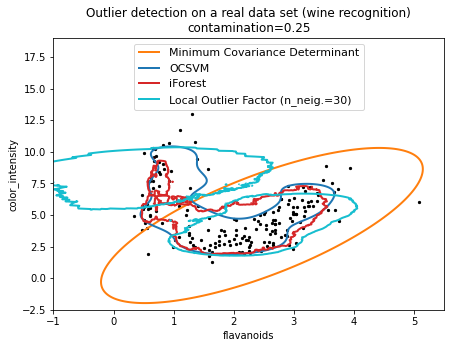

In [102]:
# Get data
features = ['flavanoids', 'color_intensity']
X2 = data[features].to_numpy()  # "banana"-shaped

# Learn a frontier for outlier detection with several classifiers
xx2, yy2 = np.meshgrid(np.linspace(-1, 5.5, 500), np.linspace(-2.5, 19, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    CS = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i]
    )
    legend2[clf_name], _ = CS.legend_elements()

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

# Plot the results (= shape of the data points cloud)
plt.figure(2)  # "banana" shape
plt.title("Outlier detection on a real data set (wine recognition)\ncontamination=0.25")
plt.scatter(X2[:, 0], X2[:, 1], color="black", s=5)
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend(
    [leg_h[0] for leg_h in legend2_values_list],
    [leg_key for leg_key in legend2_keys_list],
    loc="upper center",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.ylabel("color_intensity")
plt.xlabel("flavanoids")

plt.gcf().set_size_inches(7,5)
plt.savefig('wine_2.png', dpi=150)
plt.show()